In [145]:
# coding:utf8
import requests, json
import pandas as pd
import pyecharts
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = 'Arial Unicode MS'

In [175]:
# 获取输入的股票信息
def get_stock_with_input():

    code_name = input("输入查询的股票名称及代码，如'万华化学-600309.SH,'")
    stock_code = ''
    stock_name = ''
    if code_name == '':
        stock_code = '600309.SH'
        stock_name = '万华化学'
    else:
        stock_name = code_name.split('-')[0]
        stock_code = code_name.split('-')[1]

    print('股票名称:',stock_name)
    print('股票代码:',stock_code)

    return (stock_name, stock_code)

In [176]:
# 获取相关北上数据
def get_north_with_stock_code(stock_code):
    MUTUAL_TYPE = ''
    if stock_code.endswith('.SZ'):
        MUTUAL_TYPE = '003'
    else:
        MUTUAL_TYPE = '001'

    url = 'https://datacenter.eastmoney.com/securities/api/data/get?type=RPT_MUTUAL_STOCK_HOLDRANKN&sty=SECURITY_CODE,SECUCODE,SECURITY_NAME,TRADE_DATE,IS_ADJ_DATE,HOLD_MARKET_CAP,HOLD_SHARES,FREE_SHARES_RATIO,TOTAL_SHARES_RATIO,PARTICIPANT_NUM,ADD_MARKET_CAP,ADD_SHARES_REPAIR,ADD_SHARES_AMP,CLOSE_PRICE,CHANGE_RATE,MUTUAL_TYPE&callback=&extraCols=&filter=(INTERVAL_TYPE="1")(MUTUAL_TYPE="{}")(SECUCODE="{}")&p=1&ps=100&sr=-1&st=TRADE_DATE&token=&var=&source=DataCenter&client=APP'.format(MUTUAL_TYPE,stock_code)

    response = requests.get(url)
    print(json.dumps(response.json(), indent=4))
    if response.status_code == 200:
        response_json = response.json()
        if response_json['success'] is True:
            return response_json['result']['data']
    else:
        print('数据请求失败，请重试.')



In [181]:
# 绘制收盘价与北上资金折线图
from mpl_toolkits.axes_grid1 import host_subplot

def draw_north_price(north_arr):
    north_arr = reversed(north_arr)
    df = pd.DataFrame(north_arr)
    # 替换日期字符串为索引
    trade_date_df = df['TRADE_DATE']
    date_indexs = [pd.Timestamp(i) for i in trade_date_df]
    df['TRADE_DATE'] = date_indexs

    stock_name = df['SECURITY_NAME'][0]
    
    # 画图
    # 持仓占流通股本比
    host = host_subplot(111)
    par = host.twinx()

    plt.title(stock_name)
    host.set_ylabel("股价")
    par.set_ylabel("北上持仓占总股本比%")

    p1, = host.plot(df['TRADE_DATE'], df['CLOSE_PRICE'], label="股价")
    p2, = par.plot(df['TRADE_DATE'], df['FREE_SHARES_RATIO'], label="北上持仓占总股本比%")

    leg = plt.legend()

    host.yaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.yaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.show()

In [184]:
stock_name, stock_code = get_stock_with_input()

股票名称: 海螺水泥
股票代码: 600585.SH


In [185]:
# 获取北上资金近100日数据
north_arr = get_north_with_stock_code(stock_code)

-45168411.7016,
                "ADD_SHARES_REPAIR": -786391,
                "ADD_SHARES_AMP": -0.20037182,
                "CLOSE_PRICE": 57.5,
                "CHANGE_RATE": -0.450138504155,
                "MUTUAL_TYPE": "001"
            },
            {
                "SECURITY_CODE": "600585",
                "SECUCODE": "600585.SH",
                "SECURITY_NAME": "\u6d77\u87ba\u6c34\u6ce5",
                "TRADE_DATE": "2020-11-17 00:00:00",
                "IS_ADJ_DATE": "\u5426",
                "HOLD_MARKET_CAP": 22668828940,
                "HOLD_SHARES": 392465875,
                "FREE_SHARES_RATIO": 9.8124,
                "TOTAL_SHARES_RATIO": 7.406,
                "PARTICIPANT_NUM": 68,
                "ADD_MARKET_CAP": 4072343.5742,
                "ADD_SHARES_REPAIR": 70502,
                "ADD_SHARES_AMP": 0.01796708,
                "CLOSE_PRICE": 57.76,
                "CHANGE_RATE": 1.761804087385,
                "MUTUAL_TYPE": "001"
            },
       

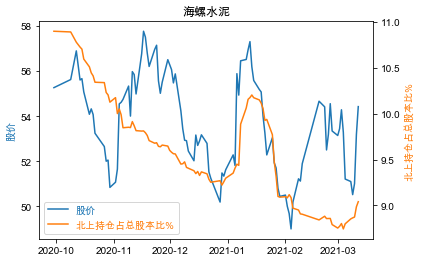

In [186]:
# 画图
draw_north_price(north_arr)